In [32]:
import os
import sys
import math
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
os.chdir('C:/Users/himan/Downloads/ASTE/')

In [33]:
"""
Processing the data
"""

def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: torch.Tensor.
        y_train: torch.Tensor.
        X_test: torch.Tensor.
        y_test: torch.Tensor.
        scaler: MinMaxScaler.
    """
    
#     attr = 'Lane 1 Flow (Veh/5 Minutes)'
    attr = 'Flow'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = torch.tensor(train[:, :-1], dtype=torch.float32)
    y_train = torch.tensor(train[:, -1], dtype=torch.float32)
    X_test = torch.tensor(test[:, :-1], dtype=torch.float32)
    y_test = torch.tensor(test[:, -1], dtype=torch.float32)

    return X_train, y_train, X_test, y_test, scaler

In [70]:
"""
Functions for the model
"""

def MAPE(y_true, y_pred):
    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred):
    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)


def plot_results(y_true, y_preds):
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=276, freq='5min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    
    ax.plot(x, y_preds, label='LSTM')

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

In [35]:
"""
Defination of NN model
"""

class LSTMModel(nn.Module):
    def __init__(self, units):
        """
        LSTM (Long Short-Term Memory)
        Build LSTM Model.

        # Arguments
            units: List[int], number of input, output, and hidden units.
        """
        
        super(LSTMModel, self).__init__()
        
        # First LSTM layer with return sequences
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=units[1], batch_first=True)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=units[1], hidden_size=units[2], batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # Fully connected layer
        self.fc = nn.Linear(units[2], units[3])
        
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use the last sequence output
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x

In [50]:
"""
Defination of Train the NN model.
"""

def train_model(model, X_train, y_train, config, device):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    optimizer = optim.RMSprop(model.parameters())
    criterion = torch.nn.MSELoss()

    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=config["batch"], shuffle=True)
    name = 'Lstm'
    model.to(device)

    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(), name + '.pt')

In [77]:
"""
Train the NN model.
"""

lag = 12
config = {"batch": 256, "epochs": 10}
file1 = 'Train_data.csv'
file2 = 'Test_data.csv'
X_train, y_train, _, _, _ = process_data(file1, file2, lag)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
m = LSTMModel([12, 64, 64, 1])

train_model(m, X_train, y_train, config, device)

explained_variance_score:0.000000
mape:466.108504%
mae:11.862401
mse:156.345343
rmse:12.503813
r2:-8.827420
(276,) (276,)


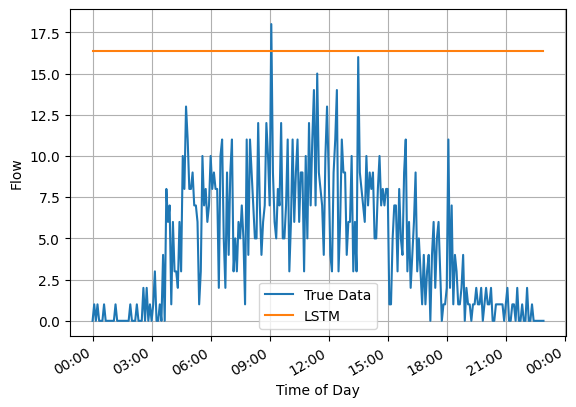

In [78]:
"""
Predict the NN model.
"""

# Load the trained model for evaluation
lstm = LSTMModel([12, 64, 64, 1]).to(device)  
lstm.load_state_dict(torch.load('lstm.pt'))
lstm.eval()

_, _, x_test, y_test, scaler = process_data(file1, file2, lag)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

x_test_torch = x_test.unsqueeze(-1).to(device)
# X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predicted = lstm(x_test_torch).cpu().numpy()

predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]

eva_regress(y_test, predicted)
plot_results(y_test[: 276], predicted)
